In [47]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

First, we define some functions for computing the output of the multilayer perceptron.

In [2]:
def softmax(x):
    '''
    Input
         x: a vector in ndarray format, 
            typically the raw score of prediction.
    Output 
         a vector in ndarray format,
         typically representing the predicted class probability.
    '''
    res = np.exp(x-np.max(x))
    return res/np.sum(res)

def cross_entropy(y, p):
    '''
    Input
        y: an int representing the class label
        p: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(p)
    return log_likelihood[y]

def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    return np.maximum(x, 0)

Next, we define the structure and some utility functions of our multi-layer perceptron.

In [191]:
class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
    
    def load_params(self, params):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        
        self.z1 = np.matmul(x,W1)+b1
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        
        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)
    
    def gradient(self,x,y_onehot):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        
        #######################################
        #
        # TODO
        #
        #######################################
        
        p = self.forward(x)
        
        first_term = ((p-y_onehot) @ self.W4.T)
        second_term = ((np.diag(self.h3 > 0) @ self.W3.T) 
                       @ (np.diag(self.h2 > 0) @ self.W2.T) 
                       @ (np.diag(self.h1 > 0) @ self.W1.T))
        return first_term @ second_term
      
    def attack_fast_gradient_sign(self,x,y,grad=None):
        if grad is None:
            grad = self.gradient(x, y)
        dx = np.sign(grad)
        return x + self.eps * dx
      
    def attack_all_eps(self,x,y):
        return x + self.eps * np.ones(len(x))
      
    def attack_fast_gradient_norm(self,x,y, grad=None):
        if grad is None:
            grad = self.gradient(x, y)
        grad = grad/np.abs(grad).max()
        return x + self.eps * grad
      
    def attack_fast_gradient_sign_threshold(self,x,y,grad=None):
        if grad is None:
            grad = self.gradient(x, y)
        grad = self.gradient(x, y)
        grad[np.abs(grad) < 0.01] = 0
        grad = np.sign(grad)
        return x + self.eps * grad
      
    def attack_fast_gradient_exp_temperature(self,x,y,T,grad=None):
        if grad is None:
            grad = self.gradient(x, y)
        grad_sign = np.sign(grad)
        grad_exp = np.exp(np.abs(grad)/T)
        grad_exp_sign = grad_exp * grad_sign
        dx = grad_exp_sign/np.abs(grad_exp_sign).max()
        return x + self.eps * dx
    
    def attack(self,x,y):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        
        #######################################
        #
        # TODO
        #
        #######################################
        
        return x

Now, let's load the pre-trained model and the test data.

In [192]:
X_test = np.load("./data/X_test.npy")
Y_test = np.load("./data/Y_test.npy")

Y_test_onehot = np.zeros((len(Y_test), 10))
Y_test_onehot[np.arange(len(Y_test)), Y_test] = 1

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./data/"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)

Check if the image data are loaded correctly. Let's visualize the first image in the data set.

This is an image of Number 7


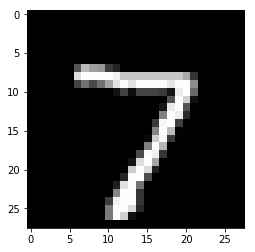

In [187]:
x, y = X_test[0], Y_test[0]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

Check if the model is loaded correctly. The test accuracy should be 97.6%

In [203]:
def attack_experiment(attack_methods, nTest = 1000, compute_original=False):
    inds = np.arange(len(Y_test_onehot))
    np.random.shuffle(inds)
    inds = inds[:nTest]
    X_test_permuted = X_test[inds]
    Y_test_onehot_permuted = Y_test_onehot[inds]
    Y_test_permuted = Y_test[inds]
    
    if compute_original:
      Y_pred = np.zeros((nTest, len(attack_methods)+1))
    else:
      Y_pred = np.zeros((nTest, len(attack_methods)))
      
    for i in tqdm(range(nTest)):
        x, y = X_test_permuted[i], Y_test_onehot_permuted[i]
        grad = clf.gradient(x,y)
        all_x_advs = [attack(x,y,grad) for attack in attack_methods]
        if compute_original:
          Y_pred[i] = [clf.predict(x)] + [clf.predict(x_adv) for x_adv in all_x_advs]
        else:
          Y_pred[i] = [clf.predict(x_adv) for x_adv in all_x_advs]
    accs = (np.sum(Y_pred.T == Y_test_permuted, axis=1)*1.0/nTest).T
    return accs

In [204]:
def attack_fast_grad_temperature(T):
  def attack(x, y, grad):
    return clf.attack_fast_gradient_exp_temperature(x, y, T, grad)
  return attack

In [ ]:
all_accs = []
for i in tqdm(range(10)):
  accs = attack_experiment([clf.attack_fast_gradient_sign, 
                          attack_fast_grad_temperature(1),
                          attack_fast_grad_temperature(2),
                          attack_fast_grad_temperature(4),
                          attack_fast_grad_temperature(0.5),
                           attack_fast_grad_temperature(0.01)], nTest=1000)
  all_accs.append(accs)

In [199]:
accs

array([0.02  , 0.02  , 0.02  , 0.02  , 0.0225])

Label is 9 Predicted as 7


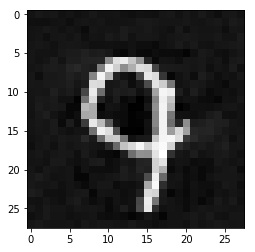

In [91]:
pixels = x_adv.reshape((28,28))
print("Label is", np.argmax(y), "Predicted as", clf.predict(x_adv))
plt.imshow(pixels,cmap="gray")

Have fun!

In [26]:
(np.diag(clf.h1 > 0) @ clf.W1.T).shape

(2048, 784)

In [34]:
(np.diag(clf.h3 > 0) 
   @ clf.W3.T).shape

(512, 512)

In [30]:
(clf.forward(x) @ clf.W4.T).shape

(512,)